# NLP Application with ML

## Sentiment Classification of Airline Tweets

### The Data

Source: https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
!pip install scikit-learn-intelex

In [28]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [29]:
!pip install autocorrect

In [30]:
!pip install contractions

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import contractions
from autocorrect import Speller

import warnings
warnings.filterwarnings("ignore");
plt.rcParams["figure.figsize"] = (9,5)
pd.set_option('display.max_columns', 50)

In [32]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\serda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\serda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\serda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\serda\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [33]:
df = pd.read_csv("airline_tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


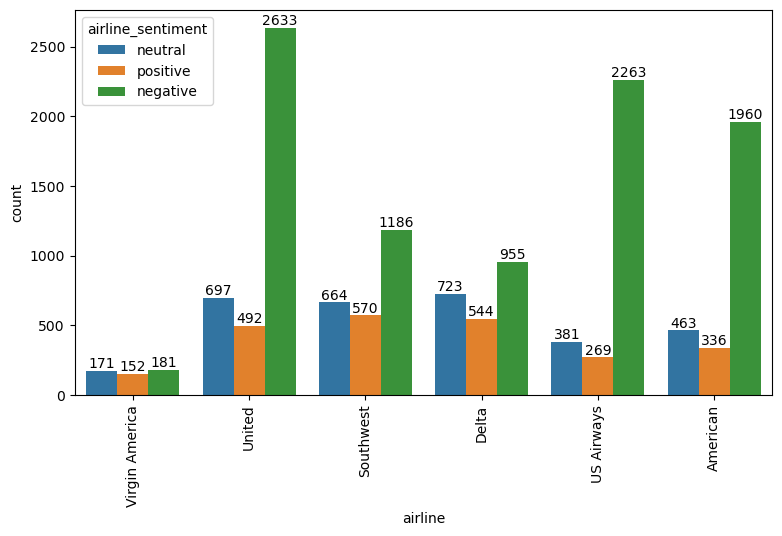

In [34]:
ax = sns.countplot(data = df,
                   x="airline",
                   hue="airline_sentiment")
for p in ax.containers:
    ax.bar_label(p)
plt.xticks(rotation =90);

# We visualize the number of comments received by airline companies.

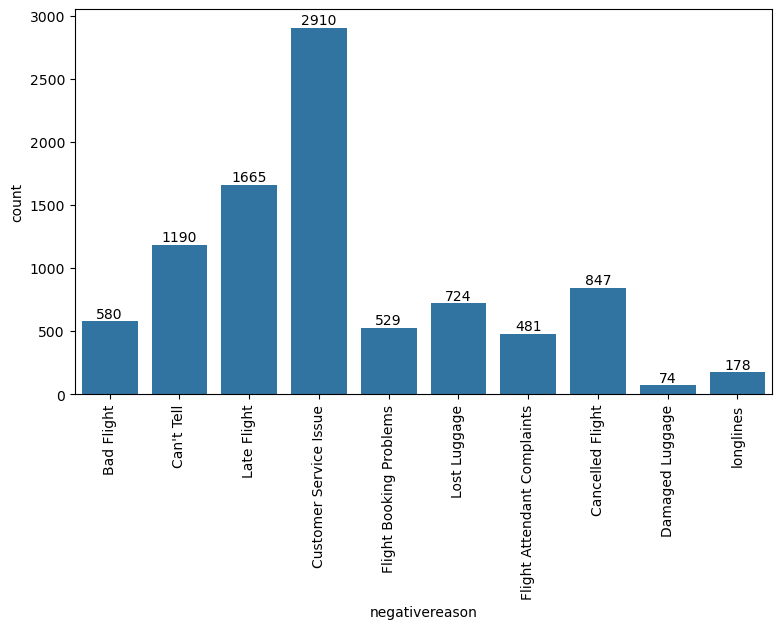

In [35]:
ax = sns.countplot(data=df,
                   x="negativereason")
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90);

# We visualize the number of reasons for negative reviews.

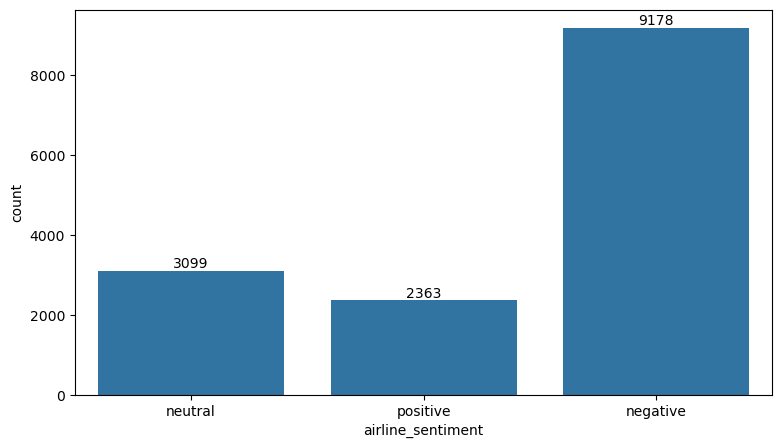

In [11]:
ax = sns.countplot(data=df,
                   x="airline_sentiment")
ax.bar_label(ax.containers[0]);

# We visualize the number of observations in our classes.

In [36]:
df["airline_sentiment"].value_counts(normalize=True)

airline_sentiment
negative    0.626913
neutral     0.211680
positive    0.161407
Name: proportion, dtype: float64

## Cleaning the Data

In [37]:
df2 = df.copy()

In [38]:
df2["text"].head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

### Cleaning URL, Tags, Mentions for Tweets

In [39]:
import re
s = "http\\:www.mynet.com #lateflight @airlines"
s = re.sub("http\S+", "", s).strip()
s

# \S represents all characters except spaces.
# http\S+ represents patterns that start with http and contain at least one or more characters after http, excluding spaces.
# http\S* represents patterns that start with http and contain at least zero or more characters after http, excluding spaces.
# regex's sub function allows us to find the patterns we are looking for in the given text and delete them or replace them with a pattern of our choice.
# re.sub("http\S+", "", s) finds and deletes patterns in the text we assign to the variable s that start with http and contain one or more characters after http, excluding spaces.
# re.sub("http\S+", "a", s) finds patterns in the text we assign to variable s that start with http and contain at least one or more characters after http, excluding spaces, and replaces them with the character a.

'#lateflight @airlines'

In [40]:
s = re.sub("#\S+", "", s)
s

# we clear the tag. But as you can see, there is a space character at the beginning of the text.

' @airlines'

In [41]:
s = re.sub("@\S+", "", s)
s.strip()

# we clear the mention.
# If we do S*, it deletes even if there is nothing after the @ sign
# \S represents all characters except spaces, so as you can see above, it does nothing with spaces. For this reason
# We remove the space characters at the beginning or end of our text with the strip() function.

''

In [42]:
stop_words = stopwords.words("english")

for i in ["not", "no"]:
  stop_words.remove(i)

In [43]:
def cleaning(data):

    #1. Removing URLS
    data = re.sub('http\S*', '', data).strip()
    data = re.sub('www\S*', '', data).strip()

    #2. Removing Tags
    data = re.sub('#\S*', '', data).strip()

    #3. Removing Mentions
    data = re.sub('@\S*', '', data).strip()

    #4. Correction of text  Warning! Runs very slow
    spell=Speller(fast=False)
    correction_data=spell(data)

    #5. Contraction of text
    contraction_data=contractions.fix(data) #correction_data

    #6. Tokenize and lowercase
    text_tokens = word_tokenize(contraction_data.lower())

    #7. Remove Puncs and numbers
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]

    #8. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #9. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]

    #10. joining
    return " ".join(text_cleaned)

In [45]:
%%time
cleaning_text = df2["text"].apply(cleaning)
cleaning_text.head()

# I clean my text and assign it to the cleaning_text variable. We will use it in the WordCloud visualization at the end of the notebook.

CPU times: total: 15min 42s
Wall time: 36min 54s


0                                                 said
1               plus added commercial experience tacky
2           not today must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                 really big bad thing
Name: text, dtype: object

## Features and Label

In [21]:
df2 =df2[["airline_sentiment", "text"]]
df2.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


## Train Test Split

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X = df2["text"]
y = df2["airline_sentiment"]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,    # Our data is imbalanced. So we need to use this to balance
                                                    random_state=101)

## Vectorization

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
%%time
vectorizer = CountVectorizer(preprocessor=cleaning, min_df=3) # ngram_range=(1,3), max_features= 1500
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

# by giving the cleaning function we defined above to the preprocessor hyper-parameter, we can perform the cleaning operation within the CountVectorizer transformation algorithm.
# min_df = 3 --> ignore tokens that occur in less than 3 documents (comments) in my corpus.
# max_df = 1000 --> ignore tokens that occur in more than 1000 documents (comments) in my corpus. Not recommended because more than 1000 may be valuable words

# max_df = 0.95 --> ignore tokens that occur in at least 95% of the comments in my corpus. >0.95 are already stop words
# min_df values like 3,4,5, max_df values of 0.95 and above are preferable.

# max_features = 1500 --> consider the first 1500 most frequently used features (tokens) in my corpus and ignore the others. It is not recommended to use it because there may be valuable words that are not in 1500. This value is very hard to set

# ngram is used for better learning of patterns in our text (noun phrases, adjective phrases, etc.).
# For the comment "Very nice TV";
# with ngram = 1 all tokens are decomposed 1 by 1. Very, beautiful, a, TV
# All tokens are decomposed 2 by 2 as ngram = 2. Very nice, nice one, one TV
# ngram = 3 as all tokens are decomposed 3 by 3. It's a beautiful, beautiful TV
# ngram_range = (1, 3) all tokens are divided into tokens 1 by 1, 2 by 2 and 3 by 3 according to ngram 1, 2 and 3
# ngram_range = (1, 4) all tokens are divided into 1 of 1, 2 of 2, 3 of 3 and 4 of 4 according to ngram 1, 2, 3 and 4

In [ ]:
X_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
pd.DataFrame(X_train_count.toarray(),
             columns=vectorizer.get_feature_names_out())

,aa,aadvantage,abc,ability,able,aboard,abq,absolute,absolutely,absurd,abysmal,ac,accept,acceptable,accepted,accepting,access,accident,accommodate,accommodating,accommodation,accomplished,according,accordingly,account,...,wth,xna,ya,yay,yea,yeah,year,yell,yelled,yelling,yep,yes,yest,yesterday,yet,yo,york,young,yr,yuma,yup,yvr,yyz,zero,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11707,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11708,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11709,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11710,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Model Comparisons - Vectorization

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score

In [ ]:
def eval(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print(confusion_matrix(y_test, y_pred))
    print("Test_Set")
    print(classification_report(y_test,y_pred))
    print("Train_Set")
    print(classification_report(y_train,y_pred_train))


## Naive Bayes

Naive Bayes is so named because of the algorithm's basic assumption that "features/tokens are independent" ("naive"). This assumption ignores the relationships between features/tokens in real-world applications and calculates probabilities for each feature/token separately. This assumption can reduce the accuracy of the algorithm, as it is often not valid in real life, but nevertheless the Naive Bayes algorithm is very widely used and gives very good results.

Bayes' Theorem is one of the basic principles of probability theory.

Bayes' Theorem, also called conditional probability, is a mathematical theory used to calculate the probability of an event occurring over the probabilities of all other events necessary for that event to occur.

https://medium.com/analytics-vidhya/na%C3%AFve-bayes-algorithm-5bf31e9032a2

**LIKELIHOOD OF POSITIVE COMMENT:**

P(positive | awesome TV bad cargo) : the probability that the comment is **"positive "** when the comment is **"awesome TV bad cargo "**.

**P(positive | awesome TV bad shipping)** = **P(awesome TV bad shipping|positive) x P(positive) / P(awesome TV bad shipping)**

P(great TV bad shipping|positive) : The probability that in a **positive** review the **TV is great** but the **cargo is bad**

P(positive) : The probability that a comment in the corpus is **positive**

P(great TV bad shipping) : the probability that **TV is great** but **cargo is bad** in a comment in the corpus


**LIKELIHOOD OF NEGATIVE COMMENT:**

P(negative | awesome TV bad shipping) : the probability that the comment is **"negative "** when the comment is **"awesome TV bad shipping "**.

**P(negative | awesome TV bad shipping)** = **P(awesome TV bad shipping|negative) x P(negative) / P(awesome TV bad shipping)**

P(great TV bad shipping|negative) : The probability that in a **negative** review the **TV is great** but the **cargo is bad**

P(negative) : Probability that a comment in the corpus is **negative**


For example, P(awesome TV, bad cargo | Positive) --> In order to calculate the probability of a positive comment being awesome TV but bad cargo, we need to know the probability of the tokens "awesome", "TV", "bad" and "cargo" occurring in positive comments in the corpus. Without this information, we cannot calculate the probability that this comment is positive.

### Alpha Hyper-Parameter for Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB # there are 3 types: Multinomial, Bernoulli, Gaussian

In [ ]:
%%time
nb = MultinomialNB(alpha=10)
nb.fit(X_train_count,y_train)

# Although MultinomialNB is recommended for multiclass data and BernoulliNB for binary data. Regardless of the type of data we have, we will try both and go with whichever one gives us the best results.

# Gaussian algorithm is not recommended for NLP data. Gaussian assumes that the data is Normal distribution. BernoulliNB for binary model

# We can use the alpha hyper-parameter to control overfiting. However, we can also use sample_weight/class_weight to eliminate overfiting since making alpha too large will degrade our model performance.

CPU times: total: 31.2 ms
Wall time: 78.2 ms


MultinomialNB(alpha=10)

In [ ]:
print("NB MODEL")
eval(nb, X_train_count, X_test_count)

NB MODEL
[[1794   28   13]
 [ 469  126   25]
 [ 253   16  204]]
Test_Set
              precision    recall  f1-score   support

    negative       0.71      0.98      0.82      1835
     neutral       0.74      0.20      0.32       620
    positive       0.84      0.43      0.57       473

    accuracy                           0.73      2928
   macro avg       0.77      0.54      0.57      2928
weighted avg       0.74      0.73      0.68      2928

Train_Set


              precision    recall  f1-score   support

    negative       0.72      0.98      0.83      7343
     neutral       0.80      0.25      0.38      2479
    positive       0.86      0.44      0.58      1890

    accuracy                           0.74     11712
   macro avg       0.79      0.56      0.60     11712
weighted avg       0.76      0.74      0.70     11712



In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

scoring = {'accuracy': make_scorer(accuracy_score),
            'precision-neg': make_scorer(precision_score, average=None, labels=["negative"]),
            'recall-neg': make_scorer(recall_score, average=None, labels = ["negative"]),
            'f1-neg': make_scorer(f1_score, average=None, labels = ["negative"])}

model = MultinomialNB(alpha=10)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.713372
train_accuracy         0.732848
test_precision-neg     0.703855
train_precision-neg    0.716139
test_recall-neg        0.978210
train_recall-neg       0.984112
test_f1-neg            0.818640
train_f1-neg           0.829006
dtype: float64

In [ ]:
!pip install scikit-plot

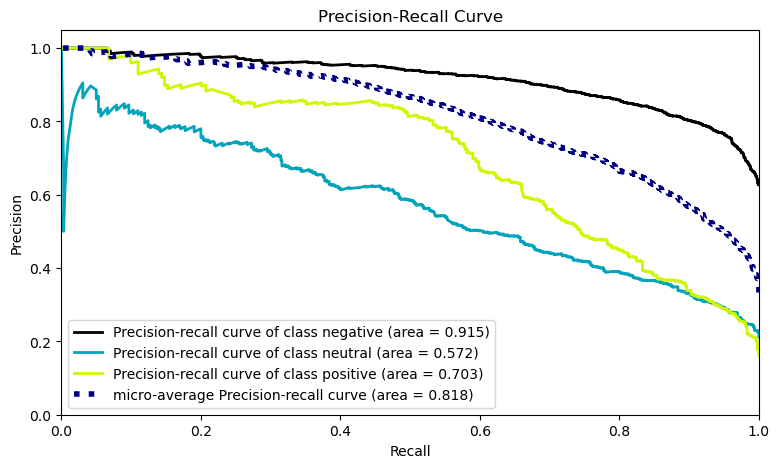

In [ ]:
from scikitplot.metrics import plot_roc, plot_precision_recall


model = MultinomialNB(alpha=10)

model.fit(X_train_count, y_train)

y_pred_proba = model.predict_proba(X_test_count)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [ ]:
pd.get_dummies(y_test)

,negative,neutral,positive
1756,True,False,False
10942,False,False,True
3797,True,False,False
6126,False,False,True
10600,True,False,False
...,...,...,...
8977,True,False,False
8509,True,False,False
8454,False,True,False
7397,True,False,False


In [ ]:
y_pred_proba

array([[9.99743922e-01, 7.16702196e-05, 1.84407937e-04],
       [7.47105179e-01, 1.18881736e-01, 1.34013085e-01],
       [9.73221348e-01, 2.41406935e-02, 2.63795857e-03],
       ...,
       [5.22714488e-01, 1.96353289e-01, 2.80932223e-01],
       [9.63160021e-01, 3.39997170e-02, 2.84026181e-03],
       [9.99973838e-01, 2.58142912e-05, 3.47462527e-07]])

In [ ]:
from sklearn.metrics import average_precision_score

y_test_dummies = pd.get_dummies(y_test)

y_pred = nb.predict(X_test_count)
nb_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
nb_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
nb_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

In [ ]:
average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

0.9153450417544192

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C = 0.02, max_iter=1000) #class_weight='balanced'
log.fit(X_train_count,y_train)

LogisticRegression(C=0.02, max_iter=1000)

In [ ]:
print("LOG MODEL")
eval(log, X_train_count, X_test_count)

LOG MODEL
[[1739   59   37]
 [ 336  241   43]
 [ 160   59  254]]
Test_Set
              precision    recall  f1-score   support

    negative       0.78      0.95      0.85      1835
     neutral       0.67      0.39      0.49       620
    positive       0.76      0.54      0.63       473

    accuracy                           0.76      2928
   macro avg       0.74      0.62      0.66      2928
weighted avg       0.75      0.76      0.74      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.79      0.96      0.87      7343
     neutral       0.73      0.45      0.56      2479
    positive       0.79      0.52      0.63      1890

    accuracy                           0.78     11712
   macro avg       0.77      0.65      0.68     11712
weighted avg       0.78      0.78      0.76     11712



In [ ]:
model = LogisticRegression(C = 0.02, max_iter=1000)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.756234
train_accuracy         0.777474
test_precision-neg     0.765170
train_precision-neg    0.781440
test_recall-neg        0.954513
train_recall-neg       0.963957
test_f1-neg            0.849381
train_f1-neg           0.863154
dtype: float64

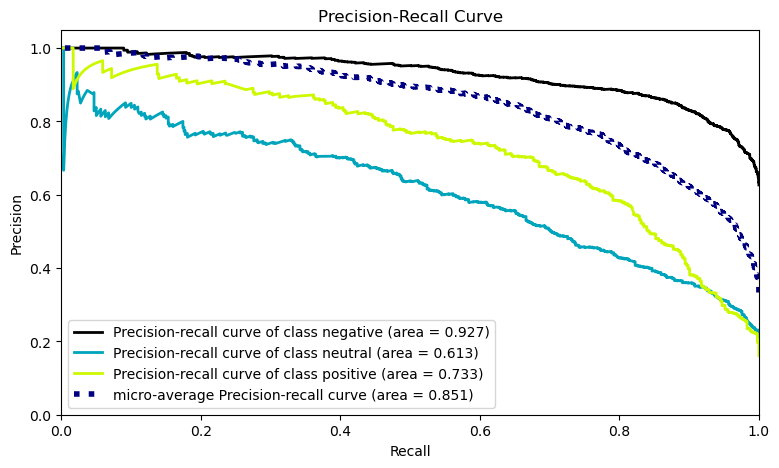

In [ ]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = LogisticRegression(C = 0.02, max_iter=1000)

model.fit(X_train_count, y_train)

y_pred_proba = model.predict_proba(X_test_count)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [ ]:
y_pred = log.predict(X_test_count)
log_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
log_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
log_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

### Balanced Logistic Regression

In [ ]:
log = LogisticRegression(C = 0.02, max_iter=1000, class_weight='balanced')
log.fit(X_train_count,y_train)

LogisticRegression(C=0.02, class_weight='balanced', max_iter=1000)

In [ ]:
# precision artti ama recall bozuldu. Biz negative yorumlari yakalamak istiyoruz bu yuzden bunu istemeyiz
print("LOG MODEL BALANCED")
eval(log, X_train_count, X_test_count)

LOG MODEL BALANCED
[[1313  416  106]
 [ 100  441   79]
 [  37   96  340]]
Test_Set
              precision    recall  f1-score   support

    negative       0.91      0.72      0.80      1835
     neutral       0.46      0.71      0.56       620
    positive       0.65      0.72      0.68       473

    accuracy                           0.72      2928
   macro avg       0.67      0.72      0.68      2928
weighted avg       0.77      0.72      0.73      2928

Train_Set


              precision    recall  f1-score   support

    negative       0.92      0.74      0.82      7343
     neutral       0.51      0.77      0.61      2479
    positive       0.67      0.74      0.70      1890

    accuracy                           0.75     11712
   macro avg       0.70      0.75      0.71     11712
weighted avg       0.79      0.75      0.76     11712



## SVM

In [ ]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.01)
svc.fit(X_train_count,y_train)

LinearSVC(C=0.01)

In [ ]:
print("SVC MODEL")
eval(svc, X_train_count, X_test_count)

SVC MODEL
[[1702   86   47]
 [ 280  285   55]
 [ 120   53  300]]
Test_Set
              precision    recall  f1-score   support

    negative       0.81      0.93      0.86      1835
     neutral       0.67      0.46      0.55       620
    positive       0.75      0.63      0.69       473

    accuracy                           0.78      2928
   macro avg       0.74      0.67      0.70      2928
weighted avg       0.77      0.78      0.77      2928

Train_Set


              precision    recall  f1-score   support

    negative       0.83      0.95      0.89      7343
     neutral       0.75      0.56      0.64      2479
    positive       0.80      0.64      0.71      1890

    accuracy                           0.82     11712
   macro avg       0.80      0.72      0.75     11712
weighted avg       0.81      0.82      0.81     11712



In [ ]:
model = LinearSVC(C=0.01)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.780654
train_accuracy         0.817111
test_precision-neg     0.807268
train_precision-neg    0.832396
test_recall-neg        0.934629
train_recall-neg       0.953425
test_f1-neg            0.866259
train_f1-neg           0.888809
dtype: float64

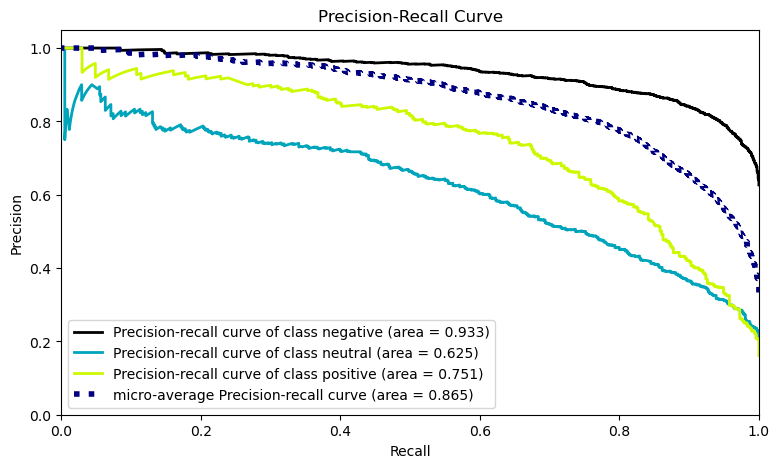

In [ ]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = LinearSVC(C=0.01)

model.fit(X_train_count, y_train)

decision_function = model.decision_function(X_test_count)

plot_precision_recall(y_test, decision_function)
plt.show();

In [ ]:
decision_function

array([[ 0.60061908, -1.45556202, -0.34837123],
       [-0.4828431 , -0.17720732, -0.34036282],
       [ 0.16340051, -0.3015076 , -0.90016275],
       ...,
       [-0.31261159, -0.20163485, -0.41023203],
       [ 0.18967045, -0.22615482, -0.95117119],
       [ 1.50883955, -1.19483441, -1.65362625]])

In [ ]:
y_pred = svc.predict(X_test_count)
svc_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
svc_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
svc_AP_neg = average_precision_score(y_test_dummies["negative"], decision_function[:, 0])

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_count,y_train)

KNeighborsClassifier(n_neighbors=7)

In [ ]:
# Skorlar kotu, overfit var
print("KNN MODEL")
eval(knn, X_train_count, X_test_count)

KNN MODEL


[[1080  674   81]
 [ 132  432   56]
 [  56  154  263]]
Test_Set
              precision    recall  f1-score   support

    negative       0.85      0.59      0.70      1835
     neutral       0.34      0.70      0.46       620
    positive       0.66      0.56      0.60       473

    accuracy                           0.61      2928
   macro avg       0.62      0.61      0.59      2928
weighted avg       0.71      0.61      0.63      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.89      0.70      0.78      7343
     neutral       0.43      0.77      0.55      2479
    positive       0.71      0.56      0.63      1890

    accuracy                           0.69     11712
   macro avg       0.68      0.68      0.65     11712
weighted avg       0.76      0.69      0.71     11712



In [ ]:
%%time
model = KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

CPU times: total: 11.1 s
Wall time: 1min 22s


test_accuracy          0.589997
train_accuracy         0.688952
test_precision-neg     0.850938
train_precision-neg    0.893708
test_recall-neg        0.564896
train_recall-neg       0.686928
test_f1-neg            0.678823
train_f1-neg           0.776736
dtype: float64

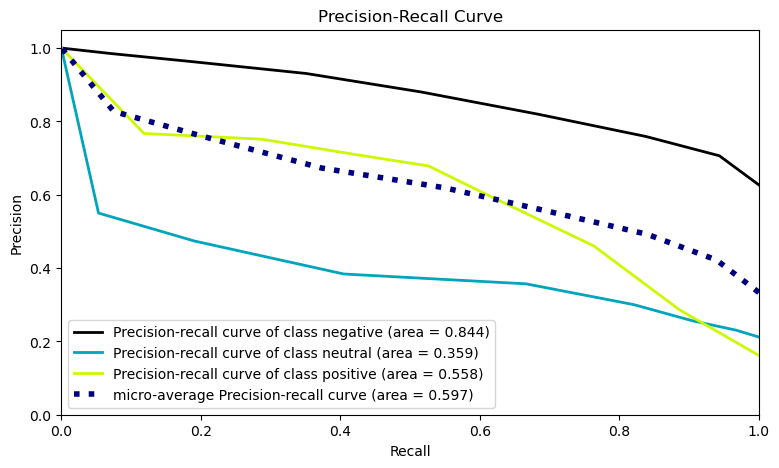

In [ ]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = KNeighborsClassifier(n_neighbors=7)

model.fit(X_train_count, y_train)

y_pred_proba = model.predict_proba(X_test_count)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [ ]:
y_pred = knn.predict(X_test_count)
knn_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
knn_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
knn_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

## Random Forest

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1) # class_weight="balanced"
rf.fit(X_train_count, y_train)

CPU times: total: 18.1 s
Wall time: 3.45 s


RandomForestClassifier(max_depth=40, n_jobs=-1, random_state=42)

In [ ]:
print("RF MODEL")
eval(rf, X_train_count, X_test_count)

RF MODEL


[[1796   11   28]
 [ 515   63   42]
 [ 216    6  251]]
Test_Set
              precision    recall  f1-score   support

    negative       0.71      0.98      0.82      1835
     neutral       0.79      0.10      0.18       620
    positive       0.78      0.53      0.63       473

    accuracy                           0.72      2928
   macro avg       0.76      0.54      0.55      2928
weighted avg       0.74      0.72      0.66      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.75      1.00      0.85      7343
     neutral       0.98      0.22      0.36      2479
    positive       0.92      0.65      0.77      1890

    accuracy                           0.78     11712
   macro avg       0.88      0.62      0.66     11712
weighted avg       0.82      0.78      0.74     11712



In [ ]:
model = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.714651
train_accuracy         0.777180
test_precision-neg     0.703626
train_precision-neg    0.746295
test_recall-neg        0.983112
train_recall-neg       0.996096
test_f1-neg            0.820204
train_f1-neg           0.853288
dtype: float64

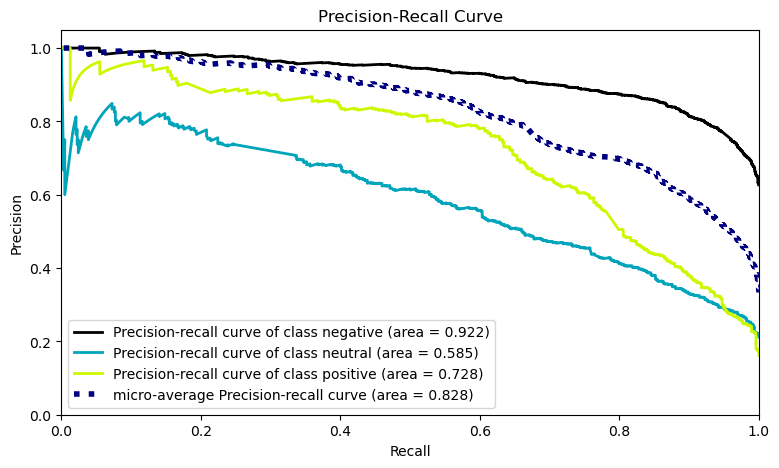

In [ ]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1)

model.fit(X_train_count, y_train)

y_pred_proba = model.predict_proba(X_test_count)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [ ]:
y_pred = rf.predict(X_test_count)
rf_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
rf_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
rf_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

### Balance Random Forest

In [ ]:
rf = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_count, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=40, n_jobs=-1,
                       random_state=42)

In [ ]:
print("RF MODEL BALANCED")
eval(rf, X_train_count, X_test_count)

RF MODEL BALANCED


[[1491  272   72]
 [ 170  387   63]
 [  59   91  323]]
Test_Set
              precision    recall  f1-score   support

    negative       0.87      0.81      0.84      1835
     neutral       0.52      0.62      0.56       620
    positive       0.71      0.68      0.69       473

    accuracy                           0.75      2928
   macro avg       0.70      0.71      0.70      2928
weighted avg       0.77      0.75      0.76      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.97      0.86      0.91      7343
     neutral       0.65      0.89      0.75      2479
    positive       0.87      0.81      0.84      1890

    accuracy                           0.86     11712
   macro avg       0.83      0.86      0.83     11712
weighted avg       0.88      0.86      0.87     11712



## Ada Boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)
ada.fit(X_train_count, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [ ]:
print("Ada MODEL")
eval(ada, X_train_count, X_test_count)

Ada MODEL


[[1556  200   79]
 [ 191  355   74]
 [  79   67  327]]
Test_Set
              precision    recall  f1-score   support

    negative       0.85      0.85      0.85      1835
     neutral       0.57      0.57      0.57       620
    positive       0.68      0.69      0.69       473

    accuracy                           0.76      2928
   macro avg       0.70      0.70      0.70      2928
weighted avg       0.76      0.76      0.76      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.87      0.88      0.88      7343
     neutral       0.62      0.62      0.62      2479
    positive       0.78      0.72      0.75      1890

    accuracy                           0.80     11712
   macro avg       0.76      0.74      0.75     11712
weighted avg       0.80      0.80      0.80     11712



In [ ]:
model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.760844
train_accuracy         0.803715
test_precision-neg     0.847971
train_precision-neg    0.868541
test_recall-neg        0.854280
train_recall-neg       0.885348
test_f1-neg            0.851075
train_f1-neg           0.876860
dtype: float64

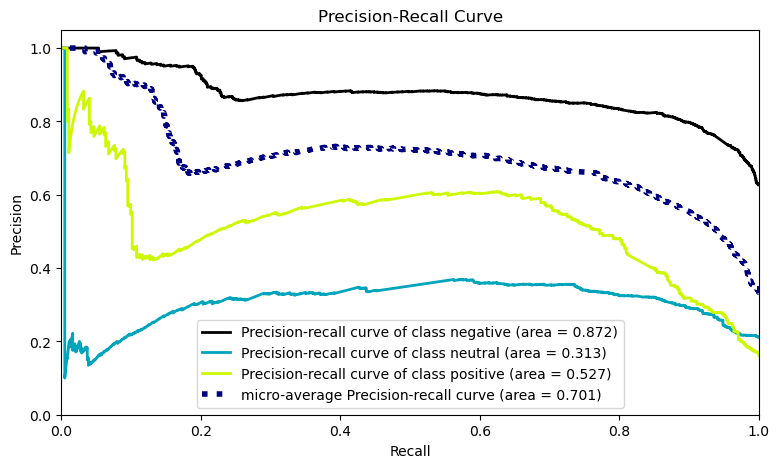

In [ ]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = AdaBoostClassifier(n_estimators= 500, random_state = 42)

model.fit(X_train_count, y_train)

y_pred_proba = model.predict_proba(X_test_count)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [ ]:
y_pred = ada.predict(X_test_count)
ada_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
ada_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
ada_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
%%time
tf_idf_vectorizer = TfidfVectorizer(preprocessor=cleaning, min_df=3)
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

# preprocessor hyper-parameter is the TfidfVectorizer that performs the cleaning process by giving the cleaning function we defined above to the hyper-parameter
# we can do it in the transformation algorithm.
# min_df = 3 --> ignore tokens that occur in less than 3 documents (comments) in my corpus.
# max_df = 1000 --> ignore tokens that occur in more than 1000 documents (comments) in my corpus.

# max_df = 0.95 --> ignore tokens that occur in at least 95% of the comments in my corpus
# min_df values like 2,3, max_df values of 0.95 and above are preferable.

# max_features = 1500 --> consider the first 1500 most frequently used features (tokens) in my corpus and ignore the others.

# ngram is used for better learning of patterns in our text (noun phrases, adjective phrases, etc.).
# For a very nice TV commentary;
# with ngram = 1 all tokens are separated 1 by 1. Very, beautiful, one, TV
# All tokens are decomposed 2 by 2 as ngram = 2. Very nice, nice one, one TV
# bgram = 3 to decompose all tokens 3 by 3. It's a beautiful, beautiful TV
# ngram_range = (1, 3) all tokens are divided into tokens 1 by 1, 2 by 2 and 3 by 3 according to ngram 1, 2 and 3
# ngram_range = (1, 4) all tokens are divided into 1 of 1, 2 of 2, 3 of 3 and 4 of 4 according to ngram 1, 2, 3 and 4

CPU times: total: 1.11 s
Wall time: 8.48 s


In [ ]:
X_train_tf_idf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.32582742, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names_out())

,aa,aadvantage,abc,ability,able,aboard,abq,absolute,absolutely,absurd,abysmal,ac,accept,acceptable,accepted,accepting,access,accident,accommodate,accommodating,accommodation,accomplished,according,accordingly,account,...,wth,xna,ya,yay,yea,yeah,year,yell,yelled,yelling,yep,yes,yest,yesterday,yet,yo,york,young,yr,yuma,yup,yvr,yyz,zero,zone
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.460588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11707,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11708,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11709,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11710,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Comparisons  TF-IDF

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

nb = MultinomialNB()
nb.fit(X_train_tf_idf,y_train)

MultinomialNB()

In [ ]:
print("NB MODEL")
eval(nb, X_train_tf_idf, X_test_tf_idf)

NB MODEL
[[1796   28   11]
 [ 430  168   22]
 [ 249   29  195]]
Test_Set
              precision    recall  f1-score   support

    negative       0.73      0.98      0.83      1835
     neutral       0.75      0.27      0.40       620
    positive       0.86      0.41      0.56       473

    accuracy                           0.74      2928
   macro avg       0.78      0.55      0.60      2928
weighted avg       0.75      0.74      0.70      2928

Train_Set


              precision    recall  f1-score   support

    negative       0.75      0.99      0.85      7343
     neutral       0.83      0.35      0.50      2479
    positive       0.91      0.51      0.65      1890

    accuracy                           0.77     11712
   macro avg       0.83      0.62      0.67     11712
weighted avg       0.80      0.77      0.75     11712



In [ ]:
model = MultinomialNB()
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.731131
train_accuracy         0.773224
test_precision-neg     0.721144
train_precision-neg    0.750796
test_recall-neg        0.978073
train_recall-neg       0.987925
test_f1-neg            0.830165
train_f1-neg           0.853190
dtype: float64

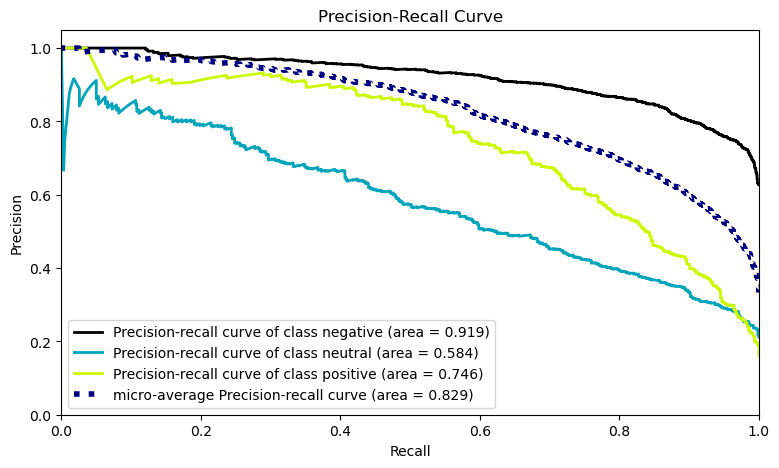

In [ ]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = MultinomialNB()

model.fit(X_train_tf_idf, y_train)

y_pred_proba = model.predict_proba(X_test_tf_idf)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [ ]:
y_pred = nb.predict(X_test_tf_idf)
nb_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
nb_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
nb_tfidf_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C=0.4, max_iter=1000)
log.fit(X_train_tf_idf,y_train)

LogisticRegression(C=0.4, max_iter=1000)

In [ ]:
print("LOG MODEL")
eval(log, X_train_tf_idf, X_test_tf_idf)

LOG MODEL
[[1750   58   27]
 [ 317  271   32]
 [ 137   47  289]]
Test_Set
              precision    recall  f1-score   support

    negative       0.79      0.95      0.87      1835
     neutral       0.72      0.44      0.54       620
    positive       0.83      0.61      0.70       473

    accuracy                           0.79      2928
   macro avg       0.78      0.67      0.70      2928
weighted avg       0.78      0.79      0.77      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.83      0.97      0.89      7343
     neutral       0.80      0.55      0.65      2479
    positive       0.87      0.63      0.73      1890

    accuracy                           0.83     11712
   macro avg       0.83      0.72      0.76     11712
weighted avg       0.83      0.83      0.82     11712



In [ ]:
model = LogisticRegression(C=0.4, max_iter=1000)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.773908
train_accuracy         0.823154
test_precision-neg     0.781390
train_precision-neg    0.817618
test_recall-neg        0.957102
train_recall-neg       0.974700
test_f1-neg            0.860343
train_f1-neg           0.889275
dtype: float64

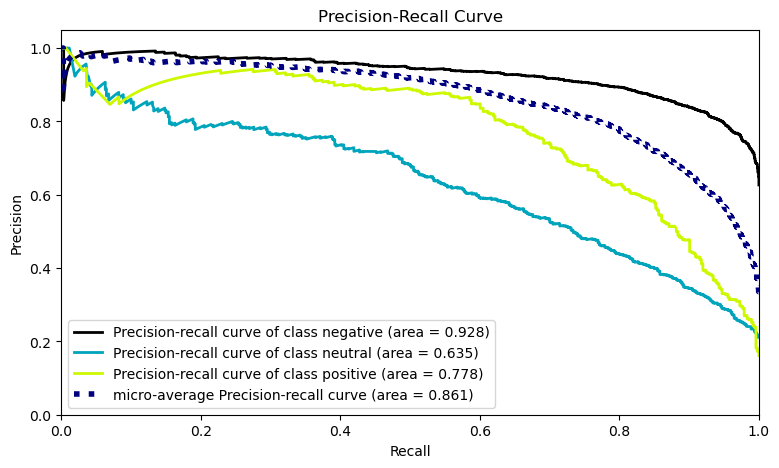

In [ ]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = LogisticRegression(C=0.4, max_iter=1000)

model.fit(X_train_tf_idf, y_train)

y_pred_proba = model.predict_proba(X_test_tf_idf)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [ ]:
y_pred = log.predict(X_test_tf_idf)
log_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
log_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
log_tfidf_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

### Balanced Logistic Regression

In [ ]:
log = LogisticRegression(C=0.4, max_iter=1000, class_weight="balanced")
log.fit(X_train_tf_idf,y_train)

LogisticRegression(C=0.4, class_weight='balanced', max_iter=1000)

In [ ]:
print("LOG MODEL BALANCED")
eval(log, X_train_tf_idf, X_test_tf_idf)

LOG MODEL BALANCED
[[1434  300  101]
 [ 121  423   76]
 [  40   71  362]]
Test_Set
              precision    recall  f1-score   support

    negative       0.90      0.78      0.84      1835
     neutral       0.53      0.68      0.60       620
    positive       0.67      0.77      0.72       473

    accuracy                           0.76      2928
   macro avg       0.70      0.74      0.72      2928
weighted avg       0.78      0.76      0.77      2928

Train_Set


              precision    recall  f1-score   support

    negative       0.94      0.81      0.87      7343
     neutral       0.61      0.80      0.69      2479
    positive       0.75      0.84      0.79      1890

    accuracy                           0.81     11712
   macro avg       0.77      0.82      0.78     11712
weighted avg       0.84      0.81      0.82     11712



## SVM

In [ ]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.1)
svc.fit(X_train_tf_idf,y_train)

LinearSVC(C=0.1)

In [ ]:
print("SVC MODEL")
eval(svc, X_train_tf_idf, X_test_tf_idf)

SVC MODEL
[[1733   67   35]
 [ 313  264   43]
 [ 125   41  307]]
Test_Set
              precision    recall  f1-score   support

    negative       0.80      0.94      0.87      1835
     neutral       0.71      0.43      0.53       620
    positive       0.80      0.65      0.72       473

    accuracy                           0.79      2928
   macro avg       0.77      0.67      0.70      2928
weighted avg       0.78      0.79      0.77      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.84      0.97      0.90      7343
     neutral       0.82      0.57      0.67      2479
    positive       0.86      0.69      0.77      1890

    accuracy                           0.84     11712
   macro avg       0.84      0.74      0.78     11712
weighted avg       0.84      0.84      0.83     11712



In [ ]:
model = LinearSVC(C=0.1)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.783385
train_accuracy         0.839253
test_precision-neg     0.795264
train_precision-neg    0.837362
test_recall-neg        0.952606
train_recall-neg       0.972491
test_f1-neg            0.866810
train_f1-neg           0.899881
dtype: float64

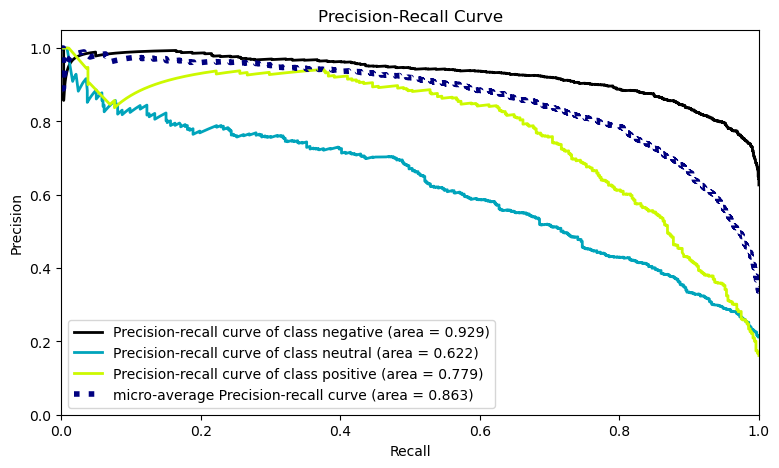

In [ ]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = LinearSVC(C=0.1)

model.fit(X_train_tf_idf, y_train)

decision_function = model.decision_function(X_test_tf_idf)

plot_precision_recall(y_test, decision_function)
plt.show();

In [ ]:
y_pred = svc.predict(X_test_tf_idf)
svc_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
svc_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
svc_tfidf_AP_neg = average_precision_score(y_test_dummies["negative"], decision_function[:, 0])

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_tf_idf,y_train)

KNeighborsClassifier(n_neighbors=7)

In [ ]:
print("KNN MODEL")
eval(knn, X_train_tf_idf, X_test_tf_idf)

KNN MODEL


[[  92 1738    5]
 [  22  585   13]
 [   7  368   98]]
Test_Set
              precision    recall  f1-score   support

    negative       0.76      0.05      0.09      1835
     neutral       0.22      0.94      0.35       620
    positive       0.84      0.21      0.33       473

    accuracy                           0.26      2928
   macro avg       0.61      0.40      0.26      2928
weighted avg       0.66      0.26      0.19      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.86      0.08      0.14      7343
     neutral       0.22      0.96      0.36      2479
    positive       0.88      0.22      0.35      1890

    accuracy                           0.29     11712
   macro avg       0.66      0.42      0.28     11712
weighted avg       0.73      0.29      0.22     11712



In [ ]:
model = KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.265705
train_accuracy         0.335852
test_precision-neg     0.775508
train_precision-neg    0.879419
test_recall-neg        0.058274
train_recall-neg       0.157559
test_f1-neg            0.104954
train_f1-neg           0.211118
dtype: float64

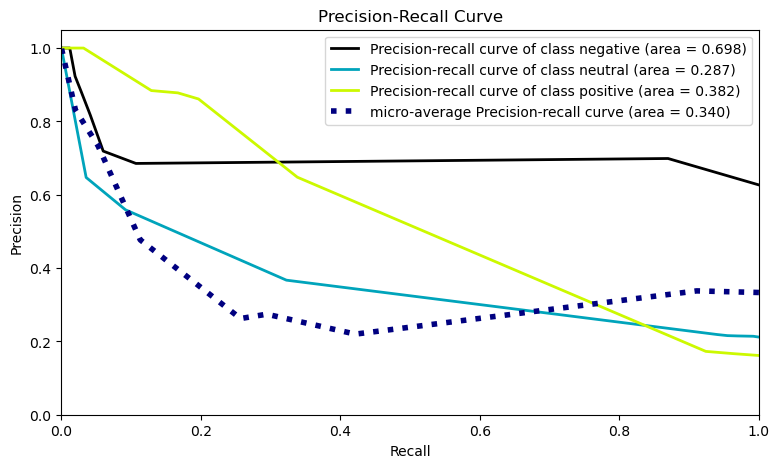

In [ ]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = KNeighborsClassifier(n_neighbors=7)

model.fit(X_train_tf_idf, y_train)

y_pred_proba = model.predict_proba(X_test_tf_idf)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [ ]:
y_pred = knn.predict(X_test_tf_idf)
knn_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
knn_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
knn_tfidf_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

## RandomForest

In [ ]:
rf = RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1)
rf.fit(X_train_tf_idf, y_train)

RandomForestClassifier(max_depth=40, n_jobs=-1, random_state=42)

In [ ]:
print("RF MODEL")
eval(rf, X_train_tf_idf, X_test_tf_idf)

RF MODEL


[[1801   10   24]
 [ 520   61   39]
 [ 235    4  234]]
Test_Set
              precision    recall  f1-score   support

    negative       0.70      0.98      0.82      1835
     neutral       0.81      0.10      0.18       620
    positive       0.79      0.49      0.61       473

    accuracy                           0.72      2928
   macro avg       0.77      0.52      0.53      2928
weighted avg       0.74      0.72      0.65      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.74      1.00      0.85      7343
     neutral       0.97      0.23      0.37      2479
    positive       0.94      0.61      0.74      1890

    accuracy                           0.77     11712
   macro avg       0.88      0.61      0.65     11712
weighted avg       0.82      0.77      0.73     11712



In [ ]:
model = RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.714309
train_accuracy         0.771725
test_precision-neg     0.701336
train_precision-neg    0.739487
test_recall-neg        0.986653
train_recall-neg       0.996989
test_f1-neg            0.819864
train_f1-neg           0.849145
dtype: float64

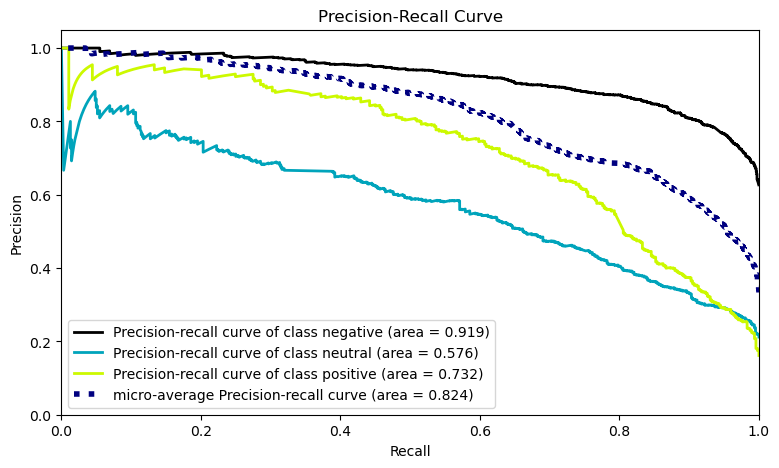

In [ ]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1)

model.fit(X_train_tf_idf, y_train)

y_pred_proba = model.predict_proba(X_test_tf_idf)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [ ]:
y_pred = rf.predict(X_test_tf_idf)
rf_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
rf_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
rf_tfidf_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

### Balanced Random Forest

In [ ]:
rf = RandomForestClassifier(100, max_depth=15, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_tf_idf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_jobs=-1,
                       random_state=42)

In [ ]:
print("RF MODEL BALANCED")
eval(rf, X_train_tf_idf, X_test_tf_idf)

RF MODEL BALANCED


[[1394  351   90]
 [ 144  406   70]
 [  52   97  324]]
Test_Set
              precision    recall  f1-score   support

    negative       0.88      0.76      0.81      1835
     neutral       0.48      0.65      0.55       620
    positive       0.67      0.68      0.68       473

    accuracy                           0.73      2928
   macro avg       0.67      0.70      0.68      2928
weighted avg       0.76      0.73      0.74      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.91      0.78      0.84      7343
     neutral       0.52      0.76      0.62      2479
    positive       0.75      0.70      0.72      1890

    accuracy                           0.77     11712
   macro avg       0.73      0.75      0.73     11712
weighted avg       0.80      0.77      0.78     11712



## Ada Boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)
ada.fit(X_train_tf_idf, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [ ]:
print("Ada MODEL")
eval(ada, X_train_tf_idf, X_test_tf_idf)

Ada MODEL


[[1566  190   79]
 [ 228  321   71]
 [  90   62  321]]
Test_Set
              precision    recall  f1-score   support

    negative       0.83      0.85      0.84      1835
     neutral       0.56      0.52      0.54       620
    positive       0.68      0.68      0.68       473

    accuracy                           0.75      2928
   macro avg       0.69      0.68      0.69      2928
weighted avg       0.75      0.75      0.75      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.86      0.88      0.87      7343
     neutral       0.62      0.61      0.61      2479
    positive       0.83      0.73      0.77      1890

    accuracy                           0.80     11712
   macro avg       0.77      0.74      0.75     11712
weighted avg       0.80      0.80      0.80     11712



In [ ]:
model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.744282
train_accuracy         0.802093
test_precision-neg     0.825340
train_precision-neg    0.856281
test_recall-neg        0.846524
train_recall-neg       0.879023
test_f1-neg            0.835764
train_f1-neg           0.867496
dtype: float64

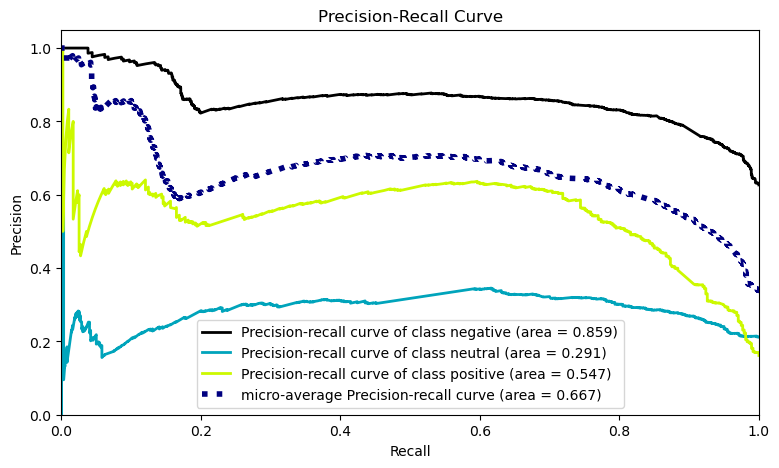

In [ ]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = AdaBoostClassifier(n_estimators= 500, random_state = 42)

model.fit(X_train_tf_idf, y_train)

y_pred_proba = model.predict_proba(X_test_tf_idf)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [ ]:
y_pred = ada.predict(X_test_tf_idf)
ada_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
ada_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
ada_tfidf_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

In [ ]:
nb_AP_neg

0.9153450417544192

## Compare Scoring

In [ ]:
compare = pd.DataFrame({"Model": ["NaiveBayes_count", "LogReg_count", "SVM_count", "KNN_count", "Random Forest_count",
                                  "AdaBoost_count", "NaiveBayes_tfidf", "LogReg_tfidf", "SVM_tfidf", "KNN_tfidf",
                                  "Random Forest_tfidf", "AdaBoost_tfidf"],

                        "F1_Score_Negative": [nb_count_f1_neg[0], log_count_f1_neg[0], svc_count_f1_neg[0], knn_count_f1_neg[0],
                                             rf_count_f1_neg[0], ada_count_f1_neg[0], nb_tfidf_f1_neg[0], log_tfidf_f1_neg[0],
                                             svc_tfidf_f1_neg[0], knn_tfidf_f1_neg[0], rf_tfidf_f1_neg[0], ada_tfidf_f1_neg[0]],

                        "Recall_Score_Negative": [nb_count_rec_neg[0], log_count_rec_neg[0], svc_count_rec_neg[0],
                                                  knn_count_rec_neg[0], rf_count_rec_neg[0], ada_count_rec_neg[0],
                                                  nb_tfidf_rec_neg[0], log_tfidf_rec_neg[0], svc_tfidf_rec_neg[0],
                                                  knn_tfidf_rec_neg[0], rf_tfidf_rec_neg[0], ada_tfidf_rec_neg[0]],

                        "Average_Precision_Score_Negative": [nb_AP_neg, log_AP_neg, svc_AP_neg, knn_AP_neg, rf_AP_neg,
                                                          ada_AP_neg, nb_tfidf_AP_neg, log_tfidf_AP_neg, svc_tfidf_AP_neg,
                                                           knn_tfidf_AP_neg, rf_tfidf_AP_neg, ada_tfidf_AP_neg]})

compare

,Model,F1_Score_Negative,Recall_Score_Negative,Average_Precision_Score_Negative
0,NaiveBayes_count,0.824638,0.977657,0.915345
1,LogReg_count,0.854545,0.947684,0.927018
2,SVM_count,0.864618,0.927520,0.933395
3,KNN_count,0.696101,0.588556,0.843904
4,Random Forest_count,0.823475,0.978747,0.921641
5,AdaBoost_count,0.850041,0.847956,0.872362
6,NaiveBayes_tfidf,0.833411,0.978747,0.918685
7,LogReg_tfidf,0.866551,0.953678,0.928265
8,SVM_tfidf,0.865202,0.944414,0.928893
9,KNN_tfidf,0.094070,0.050136,0.697595


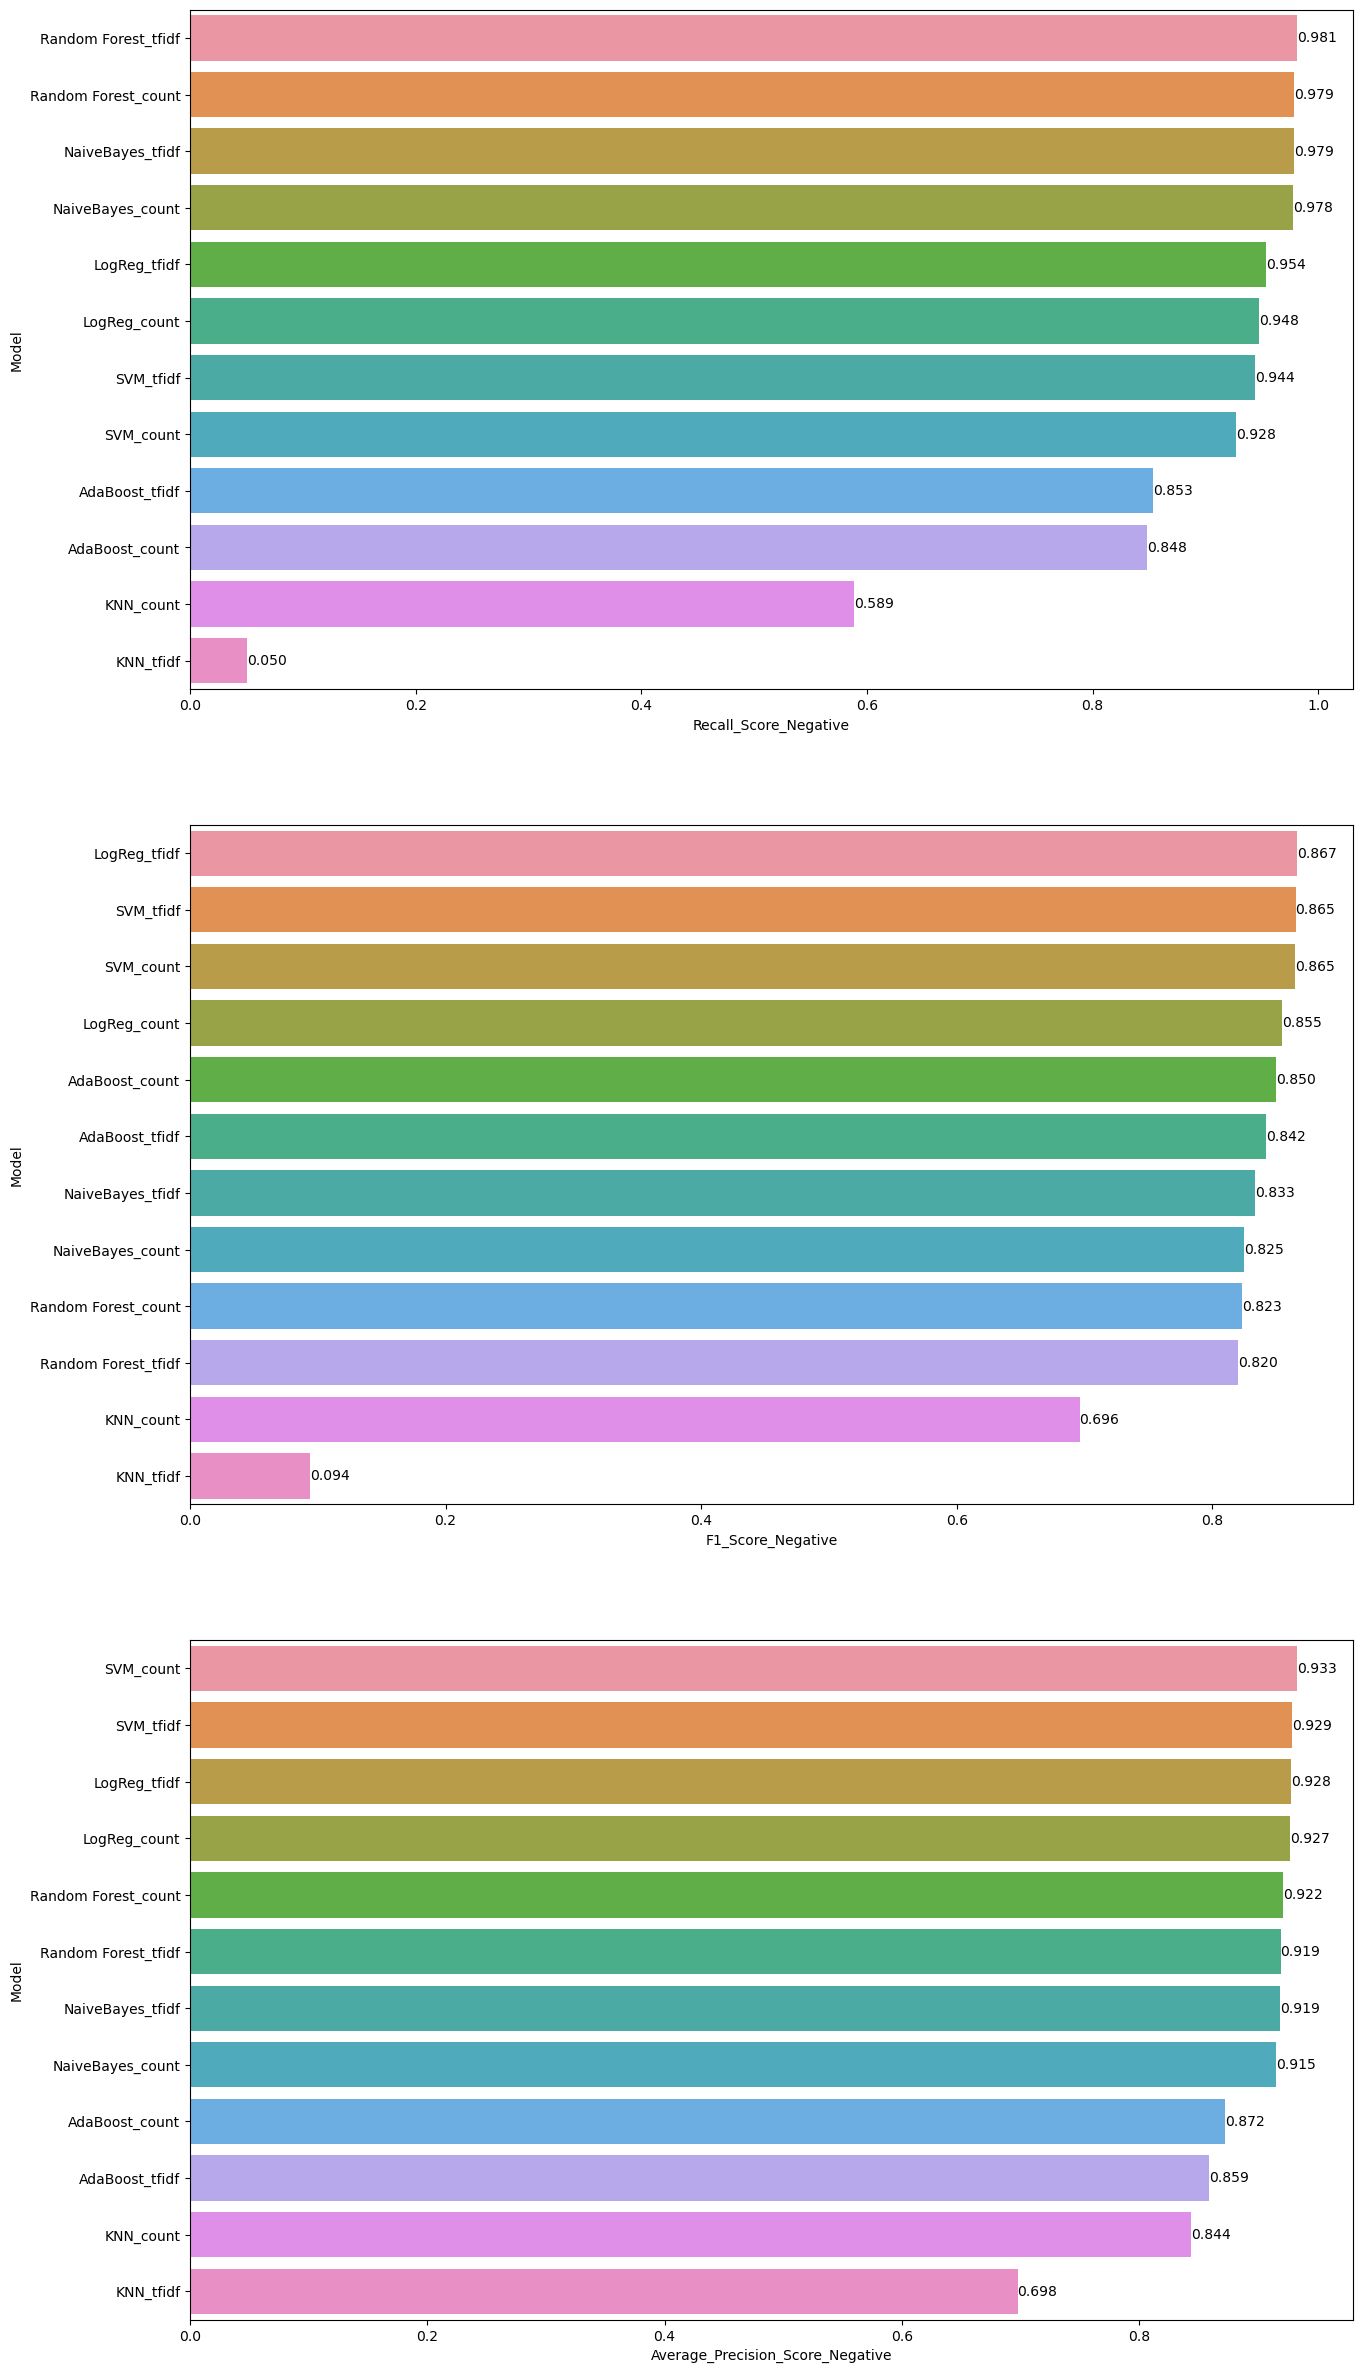

In [ ]:
plt.figure(figsize=(15,30))
plt.subplot(311)
compare = compare.sort_values(by="Recall_Score_Negative", ascending=False)
ax=sns.barplot(x="Recall_Score_Negative", y="Model", data=compare)
ax.bar_label(ax.containers[0], fmt="%.3f")

plt.subplot(312)
compare = compare.sort_values(by="F1_Score_Negative", ascending=False)
ax=sns.barplot(x="F1_Score_Negative", y="Model", data=compare)
ax.bar_label(ax.containers[0],fmt="%.3f")


plt.subplot(313)
compare = compare.sort_values(by="Average_Precision_Score_Negative", ascending=False)
ax=sns.barplot(x="Average_Precision_Score_Negative", y="Model", data=compare)
ax.bar_label(ax.containers[0],fmt="%.3f")
plt.show();

# although RF and NB recall scores are higher, F1 scores are lower, which tells us that these models are precision
# indicates that their score is lower than logreg or SVM.

# For us it is not important that the recall alone is very high. We want precision to be as high as possible along with recall.
# is required. For this reason we will continue with logreg tf-idf.

## For New Tweets, prediction with pipeline


In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipe = Pipeline([('tfidf',TfidfVectorizer(preprocessor=cleaning, min_df=3)),
                 ('log',LogisticRegression(C=0.4, max_iter=1000))])

In [ ]:
X.head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [ ]:
pipe.fit(X, y)
#22 minutes

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=3,
                                 preprocessor=<function cleaning at 0x0000022A78B33E20>)),
                ('log', LogisticRegression(C=0.4, max_iter=1000))])

## Prediction

In [ ]:
tweet = "it was not the worst flight i have ever been."
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [ ]:
tweet = "I don't like flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [ ]:
tweet = "I like flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

# neden bilemediğini aşağıda analiz edeceğiz.

array(['negative'], dtype=object)

In [ ]:
tweet = "it is amazing flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['positive'], dtype=object)

In [ ]:
tweet = "it isn't amazing flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [ ]:
tweet = "I don't think I'll ever use American Airlines anymore"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [ ]:
tweet = "ok flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['neutral'], dtype=object)

In [ ]:
tweets = cleaning_text
tweets.head()

0                                                 said
1               plus added commercial experience tacky
2           not today must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                 really big bad thing
Name: text, dtype: object

In [ ]:

for i in enumerate(tweets):
    print(i)
    break

# First of all, I want to assign index numbers to each tweet/comment with the enumerate function.
# Here I want to see the class of my target corresponding to the index numbers and comments.
# example, (1, (1, 'plus youve added commercial experience tacky') 'plus youve added commercial experience tacky' in index 1
# To see the class of the comment, I will use y[1] to see which class the comment belongs to.
# We will understand better why we are doing this in the for loops below.

(0, 'said')


In [ ]:
counter = 0
for i,j in enumerate(tweets):
    if "not like" in j and y[i]=="negative":
        counter += 1
print(counter)

# I want to find the number of comments that contain "not like" tokens together and are also negative
# This way I can better understand if there is enough data in my data for training or not.
# The model can learn from 24 "not like". In this context, the model correctly recognized the comment "I dont like flight" as negative.

24


In [ ]:
counter = 0
for i,j in enumerate(tweets):
    if "like" in j and y[i]=="positive":
        counter += 1
print(counter)

# Now let's look at why you didn't know the I like flight comment above.
# There are a total of 66 positive comments with the # like token. As we can see below, it is mentioned 306 times in negative comments.
# Since the model like token is mostly mentioned in negative comments, it made its prediction as negative.

66


In [ ]:
counter = 0
for i,j in enumerate(tweets):
    if "like" in j and y[i]=="negative":
        counter += 1
print(counter)

304


## WordCloud - Repetition of Words

## Collect Words

In [ ]:
tweets = cleaning_text
tweets

0                                                     said
1                   plus added commercial experience tacky
2               not today must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                                     really big bad thing
                               ...                        
14635                   thank got different flight chicago
14636    leaving minute late flight no warning communic...
14637                        please bring american airline
14638    money change flight not answer phone suggestio...
14639    people need know many seat next flight plz put...
Name: text, Length: 14640, dtype: object

In [ ]:
all_words = " ".join(tweets)

In [ ]:
all_words[:100]

'said plus added commercial experience tacky not today must mean need take another trip really aggres'

## Create Word Cloud

In [ ]:
!pip install wordcloud
#conda install -c conda-forge wordcloud

   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   -- ------------------------------------ 20.5/300.2 kB 330.3 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/300.2 kB 393.8 kB/s eta 0:00:01
   ---------------------------------------  297.0/300.2 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 1.7 MB/s eta 0:00:00


In [ ]:
from wordcloud import WordCloud

# Wordcloud is used to visually represent word frequency in text files. In this visual representation, the text
The visual size of the words in the # file is determined by their frequency. Thus, the most frequent words in the text file
# is displayed as the largest.

# can use wordcloud to analyze the content of comments collected from a social media account. The most frequent occurrences of these comments
# tokens can be taken into account to analyze which topic is being discussed or comes to the forefront.

In [ ]:
worldcloud = WordCloud(background_color="white", max_words =250)

# create an image with a white background color and the top 250 most frequently mentioned tokens in the corpus.

In [ ]:
worldcloud.generate(all_words)

With the # generate command, the first 250 most frequent tokens in our data are determined according to the instructions given above.

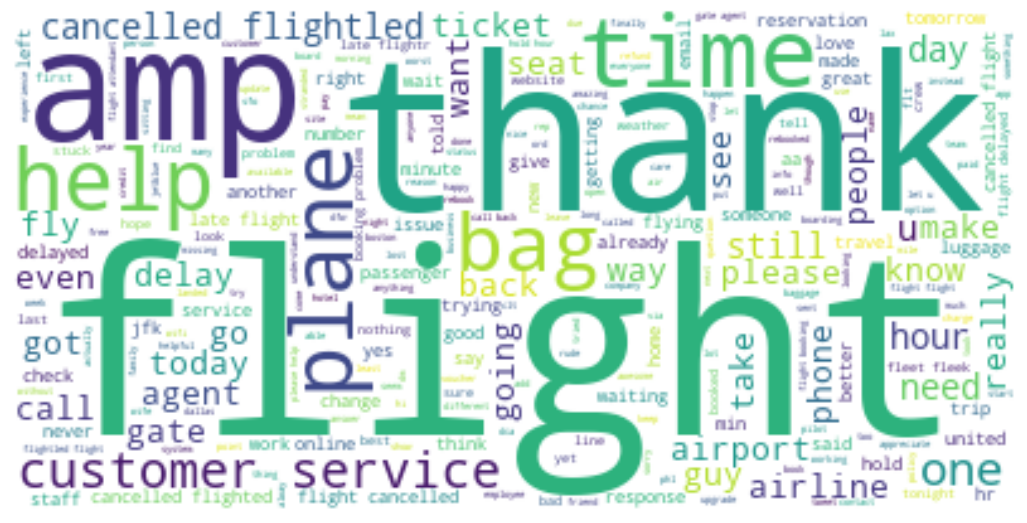

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize = (13,13))
plt.imshow(worldcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

END OF THE PROJECT